In [1]:
import numpy as np
import pyjags
import pandas as pd
import matplotlib.pyplot as plt
import corner
%matplotlib notebook

In [2]:
#To read the files, if needed
def readCODA(findex,fchain):
    names=np.loadtxt(findex, usecols=[0], dtype=str,ndmin=1)
    print names.shape
    
    names=np.array(names)
    try:
        n_vars=len(names)
    except:
        n_vars=1
    raw_table=np.loadtxt(fchain,usecols=[1])
    #print raw_table.shape
    table=raw_table.reshape([-1,n_vars],order='F')
    #print table.shape
    df = pd.DataFrame(table, columns=names)
    return df
    #names,i_start,i_stop = np.loadtxt(findex, unpack=True,format="")
  
#pyjags returns a dictionary, we translate it to Pandas
def from_dict2pd(sample, nchain=-1):
    new_dict=dict()
    for key in sample:
        aa=sample[key]
        aa_shape=aa.shape
        #First dimension is the dimension of the array of samples
        #Second dimension is the length of the chain
        # Third dimension is the number of chains
        if nchain >= aa_shape[2]:
            print "Error You asked the chain larger than your number of chains"
            return
        
        
        for i in range(aa_shape[0]):
            if aa_shape[0] > 1:
                print "Variable %s is an array of dimension %d"%(key,aa_shape[0])
                new_key="%s_%02d"%(key,i)
            else:
                new_key=key
                
            if nchain == -1:
                bb=aa[i,:,:].flatten()
            else:
                try:
                    bb=aa[i,:,nchain]
                except:
                    print "Index out of limit"
                    return
                
            new_dict[new_key]=bb
            print "Added key "+new_key
        
            
        
    sample_pd=pd.DataFrame.from_dict(new_dict)
    return sample_pd

In [3]:
#Make contour plots using corner
def contour_plot(x, y):
    fig, axes = plt.subplots(1, 1)
    #corner.hist2d(x.values, y.values, levels=[0.682689492, 0.954499736], \
    #              plot_datapoints=False, plot_density=False, ax=axes, color='blue')
    corner.hist2d(x.values, y.values, levels=[0.682689492, 0.954499736], \
                  plot_datapoints=False, plot_density=True, ax=axes, color='blue')
    
    axes.set_xlabel(x.name);
    axes.set_ylabel(y.name);

In [4]:
#set up
n_chains=3
used_chain=2

In [5]:
#Read data from file Using Pandas
input_data=pd.read_csv("data_cern.txt", dtype=float)
#Test the conversion to dictionary
print input_data.to_dict('list')

{'nrec': [23.0, 71.0, 115.0, 159.0, 200.0, 221.0, 291.0, 244.0, 277.0, 221.0, 210.0, 182.0, 136.0, 119.0, 79.0, 81.0, 61.0, 44.0, 41.0, 32.0, 32.0, 31.0, 22.0, 18.0, 11.0], 'ninj': [96.0, 239.0, 295.0, 327.0, 345.0, 316.0, 349.0, 281.0, 298.0, 235.0, 217.0, 185.0, 140.0, 121.0, 79.0, 81.0, 61.0, 45.0, 41.0, 32.0, 32.0, 31.0, 22.0, 18.0, 11.0], 'E': [2.0, 6.0, 10.0, 14.0, 18.0, 22.0, 26.0, 30.0, 34.0, 38.0, 42.0, 46.0, 50.0, 54.0, 58.0, 62.0, 66.0, 70.0, 74.0, 78.0, 82.0, 86.0, 90.0, 94.0, 98.0]}


In [6]:
#PyJags run

#Code
code = '''
model {
    for (i in 1:length(nrec))
    {
        nrec[i] ~ dbin(effi[i], ninj[i])
        effi[i] <- A + (B-A) * phi((E[i]-mu)/sigma)
    }
    
    A ~ dunif(0,1)
    B ~ dunif(0,1)
    mu ~ dunif(0,100)
    sigma ~ dunif(0,100)
}
'''


model = pyjags.Model(code, data=input_data.to_dict('list'),
                     chains=n_chains,generate_data=True, adapt=3000) 
# equivalent in data file to obsn <- c (8,4,3,5) Use c to indicate it is a struture !!

#Update
model.update(3000)

#Makes the runs
samples = model.sample(100000, vars=['A','B', 'mu', 'sigma'], thin=10)


adapting: iterations 9000 of 9000, elapsed 0:00:02, remaining 0:00:00
updating: iterations 9000 of 9000, elapsed 0:00:02, remaining 0:00:00
sampling: iterations 75447 of 300000, elapsed 0:00:08, remaining 0:00:24
sampling: iterations 168744 of 300000, elapsed 0:00:18, remaining 0:00:14
sampling: iterations 215328 of 300000, elapsed 0:00:23, remaining 0:00:09
sampling: iterations 300000 of 300000, elapsed 0:00:32, remaining 0:00:00
sampling: iterations 300000 of 300000, elapsed 0:00:32, remaining 0:00:00


In [7]:
#Translate the output dictionary to Pandas
samples_pd=from_dict2pd(samples,used_chain)

Added key A
Added key mu
Added key B
Added key sigma


In [8]:
#Show the parameters
for kk in samples_pd.keys():
    print samples_pd[kk].describe()
    print " "


count    10000.000000
mean         0.108054
std          0.061429
min          0.000040
25%          0.058754
50%          0.105302
75%          0.152351
max          0.309268
Name: A, dtype: float64
 
count    10000.000000
mean         0.990949
std          0.004133
min          0.969047
25%          0.988417
50%          0.991378
75%          0.993933
max          0.999914
Name: B, dtype: float64
 
count    10000.000000
mean        16.066630
std          1.383714
min         12.475880
25%         15.002859
50%         15.998644
75%         17.027093
max         21.106681
Name: mu, dtype: float64
 
count    10000.000000
mean        12.832985
std          1.087769
min          8.674315
25%         12.094307
50%         12.884089
75%         13.608452
max         16.701524
Name: sigma, dtype: float64
 


<IPython.core.display.Javascript object>


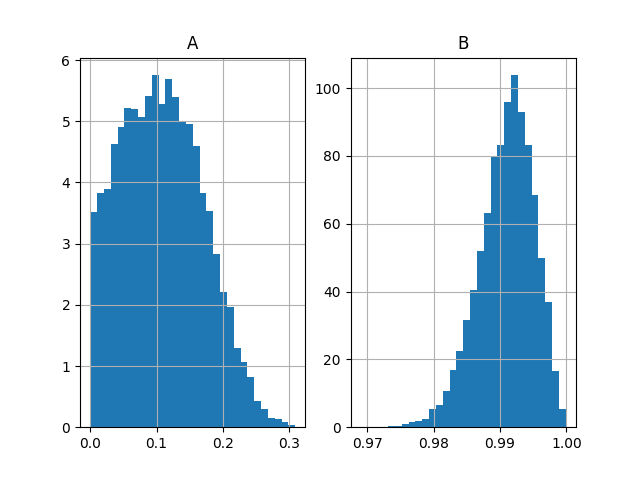

Text(0.5,1,u'B')

In [9]:
# Just two Histograms
plt.figure()
plt.subplot(1,2,1)
ax1=samples_pd['A'].hist(bins=30, normed=True, label="A")
ax1.set_title("A")
plt.subplot(1,2,2)
ax2=samples_pd['B'].hist(bins=30, normed=True, label="B")
ax2.set_title("B")


<IPython.core.display.Javascript object>


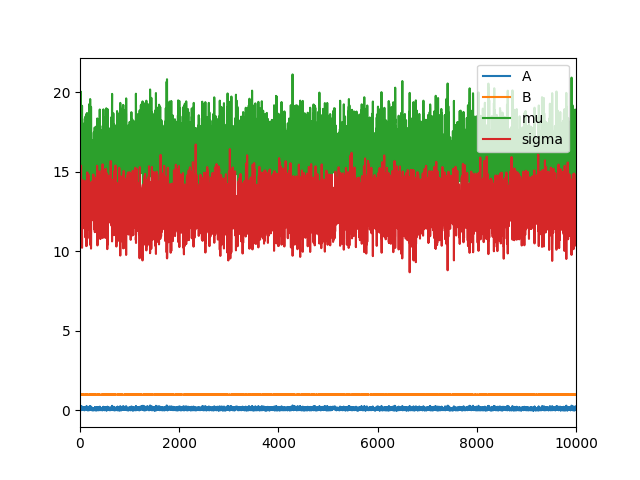

In [10]:
#Traces
samples_pd.plot()

<IPython.core.display.Javascript object>


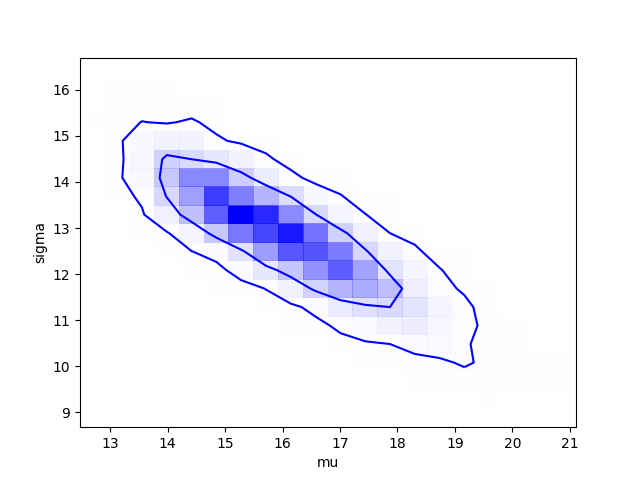

In [11]:
#Plot one contour
contour_plot(x=samples_pd['mu'], y=samples_pd['sigma'])


<IPython.core.display.Javascript object>


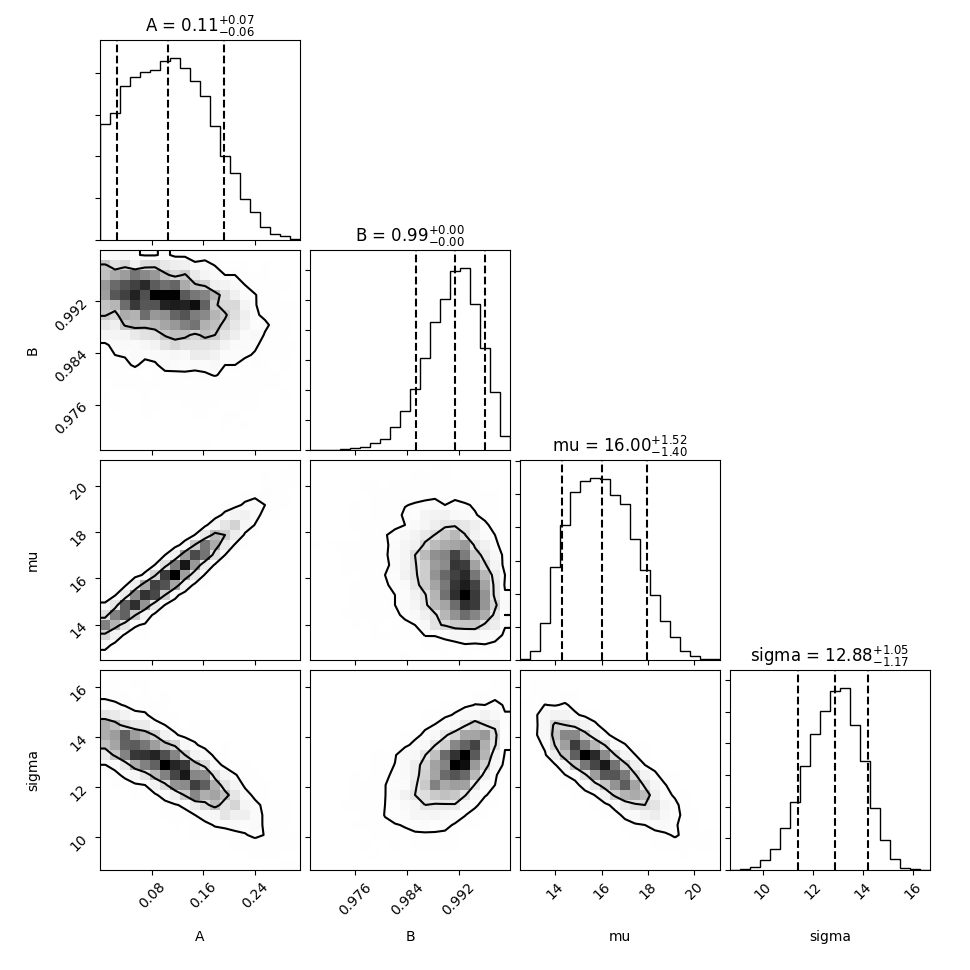

In [12]:
#Make the corner plot
def corner_from_pd(samples_pd):
    n_var=len(samples_pd.keys())
    n_sample=len(samples_pd.index)
    
    data=np.zeros([n_sample,n_var])
    for i, kk in enumerate(samples_pd.keys()):
        data[:,i]=samples_pd[kk].values
    corner.corner(data, labels=samples_pd.keys(),
                        quantiles=[0.1, 0.5, 0.9],
                        show_titles=True,levels=[0.682689492, 0.954499736],
                        plot_datapoints=False, )
corner_from_pd(samples_pd)

<IPython.core.display.Javascript object>


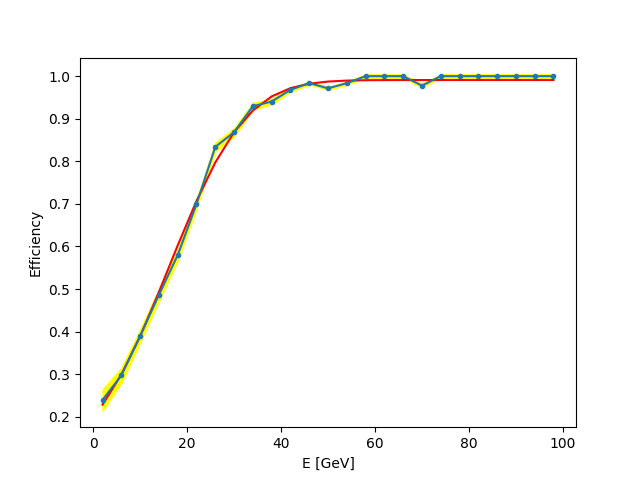

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt


In [13]:
#Write the model using python 
from scipy.special import erf
def efficiency(x, params):
    A=params['A']
    B=params['B']
    mu=params['mu']
    sigma=params['sigma']
    return A + (B-A) * 0.5*(1+erf((x-mu)/sigma/np.sqrt(2)))


#Plots the Data
plt.figure()
x=input_data['E'].values
y=input_data['nrec'].values/input_data['ninj'].values
#Expected error on binomial distribution
#https://stats.stackexchange.com/questions/29641/standard-error-for-the-mean-of-a-sample-of-binomial-random-variables
dy=np.sqrt(input_data['nrec'].values/input_data['ninj'].values*(1-input_data['nrec'].values))

ax1=plt.errorbar(x,y,yerr=dy, capsize=0, marker='.')
plt.xlabel('E [GeV]')
plt.ylabel('Efficiency')

#Define a dictionary with parameters
params=dict.fromkeys(samples.keys())
for kk in samples.keys():
    params[kk]=samples_pd[kk].values.mean()

#Plots the most probable model
y_model = efficiency(x,params)
plt.plot(x,y_model, color='red')

#Computes the confidence interval
n_samples=len(samples_pd.index)
n_x=len(x)

tmp_array=np.zeros([n_samples,n_x])
#print tmp_array.shape
for i in range(n_samples):
    for kk in samples.keys():
        params[kk]=samples_pd[kk].values[i]
        #print params[kk]    
    tmp_array[i,:]=efficiency(x,params)

#Here we use the standard deviation as a proxy of the 68% percentile
error = tmp_array.std(axis=0)
ax2=plt.fill_between(x, y-error, y+error, color='yellow')